In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
image_dir = '/kaggle/input/retina-blood-vessel/Data/train/image'
mask_dir = '/kaggle/input/retina-blood-vessel/Data/train/mask'

In [8]:
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'): 
            image = load_img(os.path.join(image_dir, filename), target_size=img_size)
            image = img_to_array(image) / 255.0  
            images.append(image)
            
            mask = load_img(os.path.join(mask_dir, filename), target_size=img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0  
            masks.append(mask)
    
    return np.array(images), np.array(masks)

In [5]:
images, masks = load_data(image_dir, mask_dir)

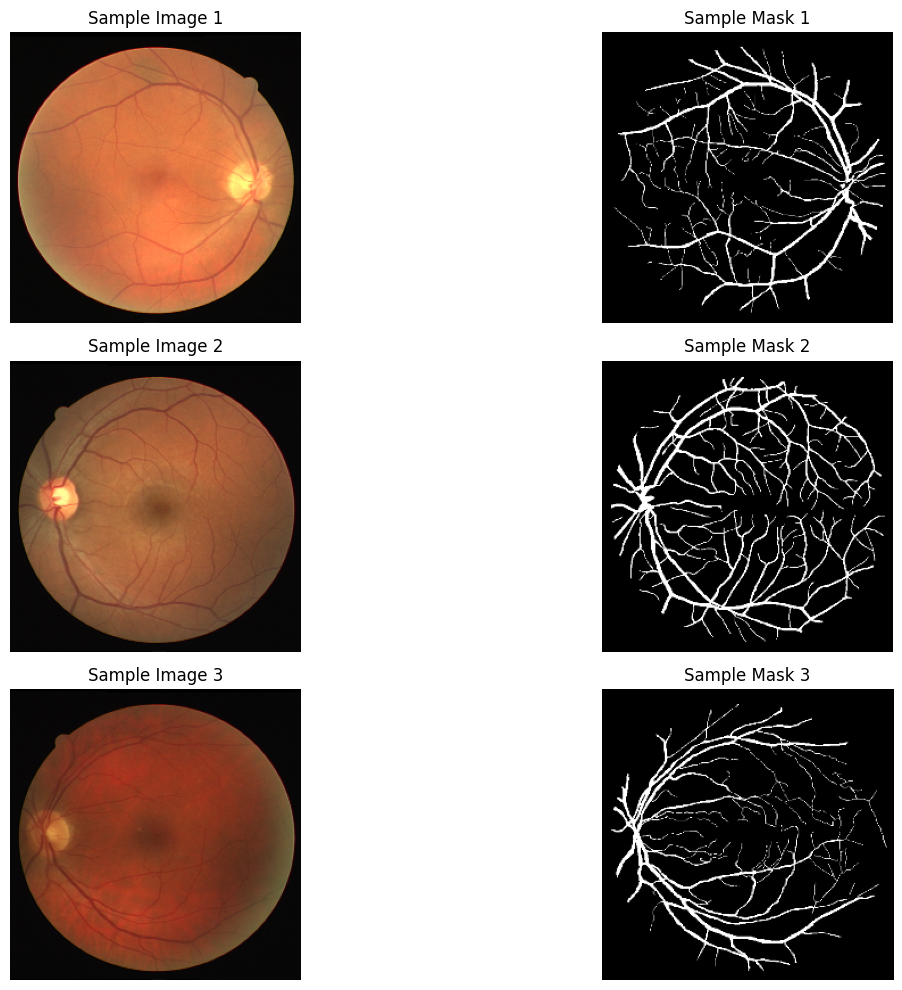

In [13]:
plt.figure(figsize=(15, 10))

sample_images = images[:3]
sample_masks = masks[:3]

for i in range(3):
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Sample Image {i+1}")
    plt.axis('off')

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(sample_masks[i].squeeze(), cmap='gray')  
    plt.title(f"Sample Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [25]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    
    up1 = layers.UpSampling2D((2, 2))(conv4)
    concat1 = layers.concatenate([up1, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.concatenate([up2, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.concatenate([up3, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs, outputs)
    return model

model = unet_model(input_size=(256, 256, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(images, masks, epochs=5, batch_size=32, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 64, 64, 512)    │              0 │ conv2d_22[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 768)    │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │      1,769,728 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4      

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 13s/step - accuracy: 0.8257 - loss: 0.6131 - val_accuracy: 0.8687 - val_loss: 13.3612
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.8780 - loss: 8.1068 - val_accuracy: 0.8687 - val_loss: 0.5976
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step - accuracy: 0.8777 - loss: 0.6077 - val_accuracy: 0.8687 - val_loss: 0.6239
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - accuracy: 0.8787 - loss: 0.6217 - val_accuracy: 0.8687 - val_loss: 0.6030
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step - accuracy: 0.8802 - loss: 0.5943 - val_accuracy: 0.8687 - val_loss: 0.5352


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


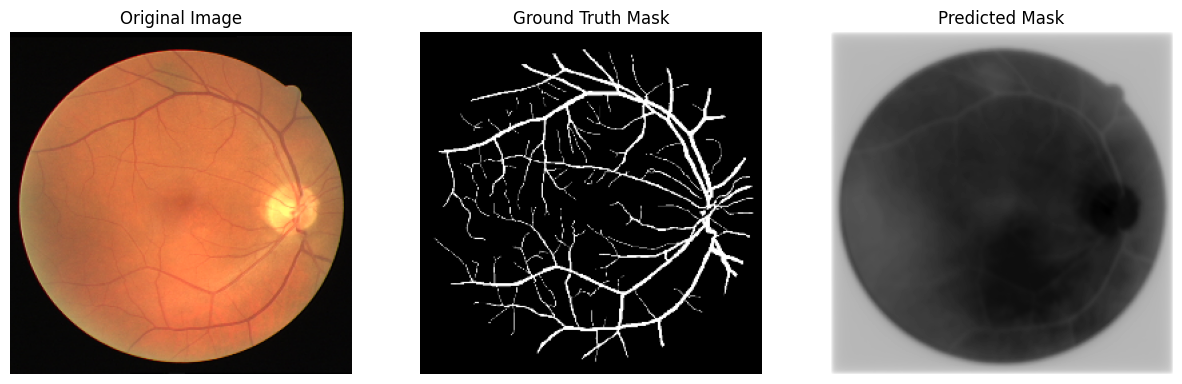

In [29]:
import matplotlib.pyplot as plt
import numpy as np

image = images[0]  
true_mask = masks[0]  

predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


In [37]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [39]:

import tensorflow as tf
from tensorflow.keras import layers, models
import segmentation_models as sm

BACKBONE = 'efficientnetb0'  

model = sm.Unet(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(images, masks, epochs=10, batch_size=32, validation_split=0.2)




Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.8177 - loss: 0.4975 - val_accuracy: 0.0803 - val_loss: 1.1973
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8469 - loss: 0.4112 - val_accuracy: 0.1246 - val_loss: 1.0758
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.8785 - loss: 0.3553 - val_accuracy: 0.2543 - val_loss: 0.9357
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8934 - loss: 0.3135 - val_accuracy: 0.3415 - val_loss: 0.8990
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.9011 - loss: 0.2786 - val_accuracy: 0.5472 - val_loss: 0.9030
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.9054 - loss: 0.2502 - val_accuracy: 0.6411 - val_loss: 0.7308
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.9094 - loss: 0.2264 - val_accuracy: 0.6662 - val_loss: 0.6962
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.9120 - loss: 0.2082 - val_accuracy: 0.7440 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


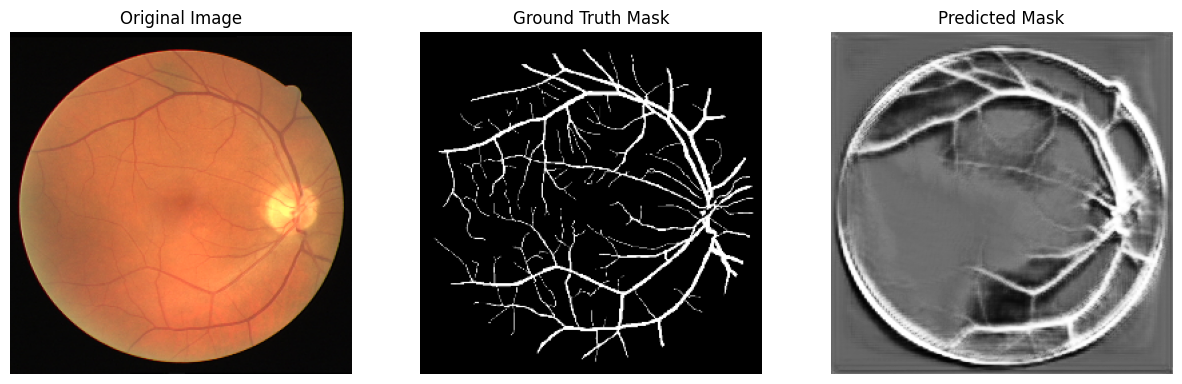

In [40]:
image = images[0] 
predicted_mask = model.predict(np.expand_dims(image, axis=0))
predicted_mask = np.squeeze(predicted_mask)

import matplotlib.pyplot as plt

true_mask = masks[0]  

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [44]:

BACKBONE = 'efficientnetb0'  

model = sm.FPN(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

history = model.evaluate(X_test, y_test, batch_size=32)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 170s 73s/step - accuracy: 0.7538 - loss: 0.6020 - val_accuracy: 0.1748 - val_loss: 2.9669
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - accuracy: 0.8136 - loss: 0.3755 - val_accuracy: 0.8715 - val_loss: 0.5669
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.8973 - loss: 0.2051 - val_accuracy: 0.8723 - val_loss: 0.6474
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - accuracy: 0.9035 - loss: 0.1706 - val_accuracy: 0.8723 - val_loss: 0.6979
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.9067 - loss: 0.1573 - val_accuracy: 0.8748 - val_loss: 0.5992
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.9089 - loss: 0.1451 - val_accuracy: 0.8784 - val_loss: 0.4992
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - accuracy: 0.9106 - loss: 0.1392 - val_accuracy: 0.8801 - val_loss: 0.4384
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.9126 - loss: 0.1326 - val_accuracy: 0.8811 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


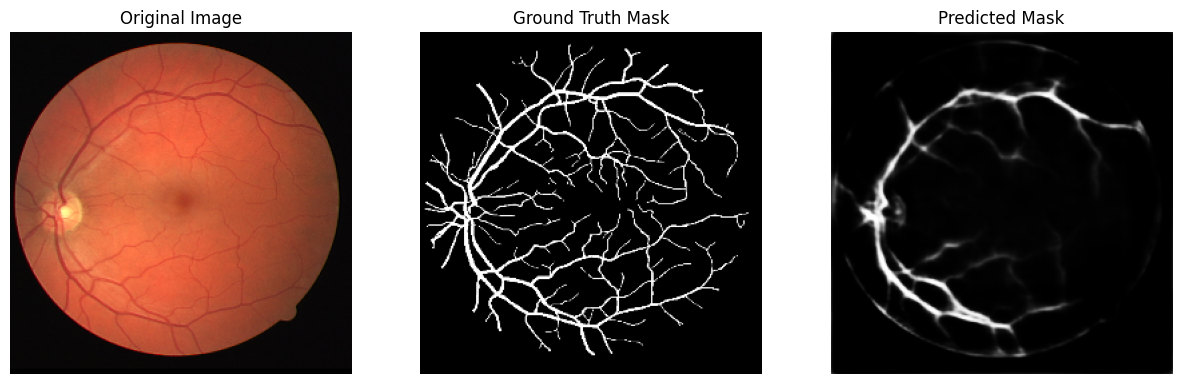

In [45]:
image = X_test[0]  

predicted_mask = model.predict(np.expand_dims(image, axis=0))  
predicted_mask = np.squeeze(predicted_mask)  

true_mask = y_test[0] 

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [53]:
import segmentation_models as sm

BACKBONE = 'efficientnetb0'

model = sm.Linknet(BACKBONE, input_shape=(256, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

history = model.evaluate(X_test, y_test, batch_size=32)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 131s 50s/step - accuracy: 0.7076 - loss: 0.6045 - val_accuracy: 0.1326 - val_loss: 1.7479
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7883 - loss: 0.5234 - val_accuracy: 0.1110 - val_loss: 2.2892
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8204 - loss: 0.4629 - val_accuracy: 0.0988 - val_loss: 2.6472
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8436 - loss: 0.4136 - val_accuracy: 0.0968 - val_loss: 2.8044
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8616 - loss: 0.3715 - val_accuracy: 0.1070 - val_loss: 2.9181
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8765 - loss: 0.3348 - val_accuracy: 0.1608 - val_loss: 2.5786
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8861 - loss: 0.3045 - val_accuracy: 0.2541 - val_loss: 2.1093
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8939 - loss: 0.2782 - val_accuracy: 0.3114 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


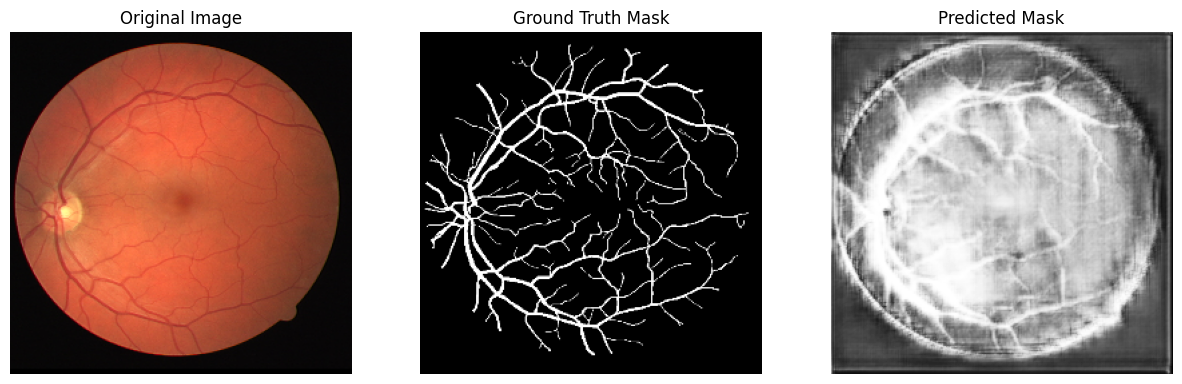

In [54]:
image = X_test[0]  

predicted_mask = model.predict(np.expand_dims(image, axis=0))  
predicted_mask = np.squeeze(predicted_mask)  

true_mask = y_test[0] 

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()